In [1]:
from datasets import DatasetDict, load_dataset, concatenate_datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import evaluate
import numpy as np
import torch

ModuleNotFoundError: No module named 'datasets'

In [51]:
dataset = load_dataset("ahsanayub/malicious-prompts").remove_columns(["id", "source"]).filter(lambda x: x["text"] is not None and x["label"] in [0, 1])

label_0 = dataset["train"].filter(lambda x: x["label"] == 0)
label_1 = dataset["train"].filter(lambda x: x["label"] == 1)

n_train = 100000
n_test = 30000
train_per_class = n_train // 2
test_per_class = n_test // 2

label_0 = label_0.shuffle(seed=42)
label_1 = label_1.shuffle(seed=42)

train_0 = label_0.select(range(train_per_class))
train_1 = label_1.select(range(train_per_class))
test_0  = label_0.select(range(train_per_class, train_per_class + test_per_class))
test_1  = label_1.select(range(train_per_class, train_per_class + test_per_class))

train_dataset = concatenate_datasets([train_0, train_1]).shuffle(seed=42)
test_dataset  = concatenate_datasets([test_0, test_1]).shuffle(seed=42)

dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [52]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 30000
    })
})

In [53]:
import re
from sentence_transformers import SentenceTransformer
from dotenv import load_dotenv
import os

load_dotenv()

hf_token = os.getenv("HUGGINGFACEHUB_API_TOKEN")

from huggingface_hub import login
login(token=hf_token)

embedding_model = SentenceTransformer('juampahc/bge-m3-m2v-1024', device='cpu')

In [54]:
import pandas as pd

def embed_dataset(batch):
  batch['embeddings'] = embedding_model.encode(batch['text'])
  return batch

embedded_dataset = dataset.map(embed_dataset, batched=True, batch_size=32)

train_df = embedded_dataset['train'].to_pandas()
train_emb = pd.DataFrame(train_df['embeddings'].tolist())
train_final = pd.concat(
    [train_df.drop(columns=['text', 'embeddings']).reset_index(drop=True),
     train_emb],
    axis=1
)

test_df = embedded_dataset['test'].to_pandas()
test_emb = pd.DataFrame(test_df['embeddings'].tolist())
test_final = pd.concat(
    [test_df.drop(columns=['text', 'embeddings']).reset_index(drop=True),
     test_emb],
    axis=1
)

Map: 100%|██████████| 30000/30000 [00:08<00:00, 3635.80 examples/s]


In [55]:
display(train_final.head())
train_final.to_csv("xgboost_train.csv", index=False)

,label,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0,-0.691989,6.549263,-6.272950,-4.412983,3.305978,-2.984964,-1.649071,-1.629389,2.728414,...,0.099708,-0.018574,0.059173,-0.028053,-0.153612,0.067139,-0.084739,0.057585,-0.051580,-0.000032
1,0,0.443557,7.165064,-5.389276,-5.175496,4.799624,0.763322,0.029768,-2.509558,1.315978,...,0.077378,0.044720,-0.013186,0.020655,-0.016158,0.034288,0.031479,0.023577,-0.043609,-0.000034
2,0,0.427453,7.228015,-5.415892,-5.082191,4.854023,0.811317,0.089146,-2.441749,1.344514,...,0.079952,0.044044,-0.008110,0.021470,-0.013289,0.035813,0.034162,0.023932,-0.043377,-0.000034
3,1,0.118078,3.976069,-9.424531,-5.166843,4.743006,-0.195376,-0.196614,0.151713,2.501611,...,0.078688,0.014200,0.003181,-0.007222,0.008223,0.049904,-0.023789,0.010475,-0.051600,-0.000033
4,1,2.283190,9.181716,-4.976474,-7.814800,4.873363,-0.986945,1.955166,-3.176492,3.358586,...,0.129768,0.140416,0.084060,0.040431,-0.053466,0.056498,0.012635,-0.036163,-0.034031,-0.000030


In [56]:
display(test_final.head())
test_final.to_csv("xgboost_test.csv", index=False)

,label,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0,-5.118596,4.815474,-8.651239,-4.184655,5.291630,-2.183558,0.366104,-1.273315,4.646743,...,0.148679,0.072431,0.098969,-0.071955,-0.038077,-0.009617,-0.096223,0.021500,-0.047327,-0.000028
1,0,-3.119127,5.408834,-8.068381,-7.705499,6.687358,-2.202411,0.997168,-0.368779,5.661228,...,0.190271,0.108317,0.071840,-0.059688,-0.078769,0.102564,-0.068399,0.082213,-0.007934,-0.000032
2,0,-0.081565,5.304894,-7.640551,-5.155474,5.099666,0.399386,-2.774071,-3.992238,1.126511,...,0.101636,-0.031759,0.067800,-0.081708,-0.100117,-0.022315,-0.145957,0.008817,-0.077980,-0.000033
3,1,-3.569139,4.216843,-8.656556,-6.224283,5.401522,-1.930195,0.143913,-1.236798,4.824371,...,0.176336,0.048016,0.065411,-0.096885,-0.032322,0.052117,-0.088491,0.107633,0.012417,-0.000031
4,1,2.811583,5.928607,-6.430428,-4.660087,3.862563,0.422649,-2.376868,-4.453062,1.454510,...,0.029709,-0.011845,0.020937,0.000374,-0.163978,-0.023478,-0.067843,-0.018351,-0.075635,-0.000035


In [63]:
features = [col for col in train_final.columns if col != 'label']
X_train = train_final[features]
y_train = train_final['label']
X_test = test_final[features]
y_test = test_final['label']

In [64]:
import xgboost as xgb

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

model.fit(X_train, y_train)

/Users/teeratc/Desktop/Research/llm-rag-manipulation/ENV/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [12:18:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


Max Precision: 0.997 at threshold 0.99
Max Recall:    1.000 at threshold 0.00
Max F1-score:  0.801 at threshold 0.42


/Users/teeratc/Desktop/Research/llm-rag-manipulation/ENV/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


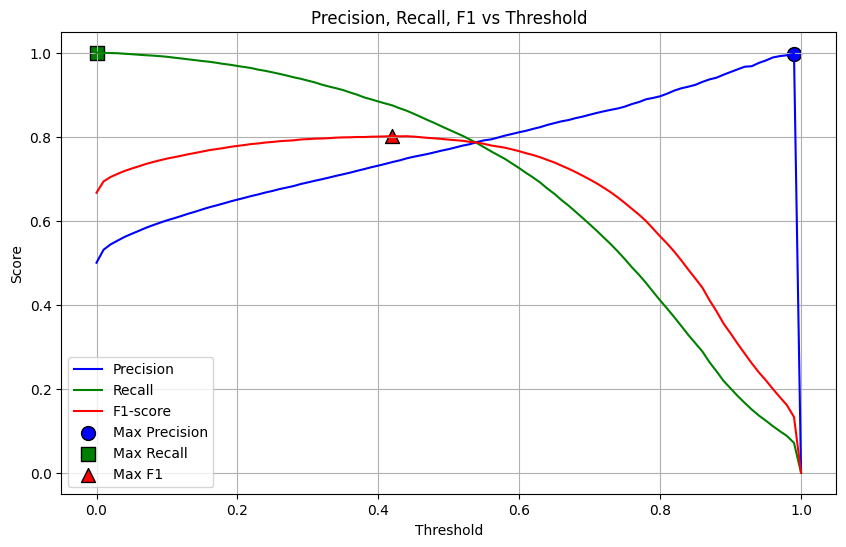

In [65]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

y_proba = model.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.0, 1.01, 0.01)
precision_scores = []
recall_scores = []
f1_scores = []

# Compute metrics for each threshold
for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

precision_scores = np.array(precision_scores)
recall_scores = np.array(recall_scores)
f1_scores = np.array(f1_scores)

# Find maxima
max_precision_idx = np.argmax(precision_scores)
max_recall_idx = np.argmax(recall_scores)
max_f1_idx = np.argmax(f1_scores)

max_precision = precision_scores[max_precision_idx]
max_recall = recall_scores[max_recall_idx]
max_f1 = f1_scores[max_f1_idx]

print(f"Max Precision: {max_precision:.3f} at threshold {thresholds[max_precision_idx]:.2f}")
print(f"Max Recall:    {max_recall:.3f} at threshold {thresholds[max_recall_idx]:.2f}")
print(f"Max F1-score:  {max_f1:.3f} at threshold {thresholds[max_f1_idx]:.2f}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label='Precision', color='blue')
plt.plot(thresholds, recall_scores, label='Recall', color='green')
plt.plot(thresholds, f1_scores, label='F1-score', color='red')

# Mark max points
plt.scatter(thresholds[max_precision_idx], max_precision, color='blue', s=100, marker='o', edgecolors='k', label='Max Precision')
plt.scatter(thresholds[max_recall_idx], max_recall, color='green', s=100, marker='s', edgecolors='k', label='Max Recall')
plt.scatter(thresholds[max_f1_idx], max_f1, color='red', s=100, marker='^', edgecolors='k', label='Max F1')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, F1 vs Threshold')
plt.grid(True)
plt.legend()
plt.show()


In [69]:
y_pred = (y_proba > 0.42).astype(int)

In [70]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

print("\nDetailed classification report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.7834
Precision: 0.7397090334949814
Recall: 0.8745333333333334
F1: 0.8014908046679293
ROC-AUC: 0.87134146

Detailed classification report:

              precision    recall  f1-score   support

           0       0.85      0.69      0.76     15000
           1       0.74      0.87      0.80     15000

    accuracy                           0.78     30000
   macro avg       0.79      0.78      0.78     30000
weighted avg       0.79      0.78      0.78     30000



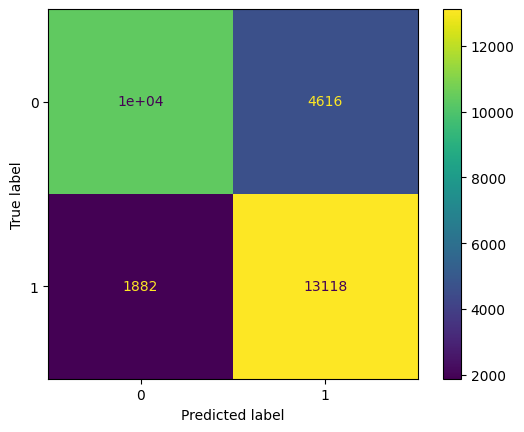

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()